# NCI Weather Bench  - 04

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import dask.array as da
import glob
import matplotlib as mpl
import pprint 
from multiprocessing.pool import Pool
from multiprocessing import set_start_method
#set_start_method("spawn")
import os

# Directories

In [95]:
NCI_dir = "/g/data/wb00/admin/testing/NCI_weatherbench/5.625deg"
wb_dir  = "/g/data/wb00/admin/testing/weatherbench/5.625deg"

def rmse (a, b):
    err2 = (((a - b)**2).sum())/len(a) 
    err  = err2**(1/2)   
    return err

err_vals  = []
year_vals = []

def yearly_rmse (p_name: str, p_id: str):
    for year in range (1979,2019):
        print (year, end= "") 
        file1 = wb_dir  + '/'+p_name+'/'+p_name+'_'+ str(year) + '_5.625deg.nc'
        ds_1 = xr.open_dataset(file1)
        file2 = NCI_dir + '/'+p_name+'/'+p_name+'_'+ str(year) + '_5.625deg.nc'
        ds_2 = xr.open_dataset(file2)
        err = 0 
        try:
            err = rmse (ds_1[p_id] ,ds_2[p_id]).values.item() 
        except ValueError:
            err = -0.05
            print(" (Error)", end = "")
        err_vals.append(err)
        year_vals.append(year)     
        del err   
        ds_1.close()
        ds_2.close()
        print (",", end= " ") 
        
# Memoery issue, hangs if insufficient memory  
# Works on 28-core, 128 GB ram, upto 2015
def rmse_a_year (y, file1, file2, p_id):
    
    isfile1 = os.path.exists(file1)
    isfile2 = os.path.exists(file2)
    if (not isfile1 or not isfile2):
        print( str(y) + " (Missing), ", end = "", flush = True)
        return y, -0.1
    
    ds_1 = xr.open_dataset(file1, chunks={'time':20}) # To reduce memeory usage, so that all processes can run. 
    ds_2 = xr.open_dataset(file2, chunks={'time':20}) 
    try:   
        rmse = ( (ds_1[p_id] - ds_2[p_id])**2).sum().values.item()/len(ds_1[p_id]) 
        rmse  = rmse**(1/2) 
        print ( str(y) + ", ", end="", flush = True)
    except Exception as e:
        print( str(y) + " (Value Error), ", end = "", flush = True)
        rmse = -0.1        
    ds_1.close()
    ds_2.close()  
 
    return y, rmse
    
def yearly_rmse_mp (wb_dir, NCI_dir, year1, year2, p_name, p_id):
    
    all_params = []
    for year in range (year1, year2+1):
        file1 = wb_dir  + '/'+p_name+'/'+p_name+'_'+ str(year) + '_5.625deg.nc'
        file2 = NCI_dir + '/'+p_name+'/'+p_name+'_'+ str(year) + '_5.625deg.nc'
        all_params.append ( (year, file1, file2, p_id) )
    #set_start_method("spawn")    
    #pprint.pprint(all_params)    
    with Pool() as pool:                  
        year_list, rmse_list  = zip(* pool.starmap(rmse_a_year , all_params) )               
    return list(year_list), list(rmse_list) 
               
        
def display_wb(file1, file2,  p_id, idx):  
    
    ds_1 = xr.open_dataset(file1)   
    ds_2 = xr.open_dataset(file2)
        
    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(5, 2, wspace=0.1, hspace=0.8)
    plt.subplot(grid[0:2, 0:3])
    plt.bar(year_vals,  height = err_vals, align='edge', width = 0.3, color='gray',label='RMSE' )
    plt.margins(x=0)
    plt.xticks(year_vals)
    plt.xlabel("Years")
    plt.ylabel("RMSE")
    ax1 = plt.subplot(grid[2:, 0])
    plt.title(file1[:49] +'\n'+ file1[49:])
    im1 = plt.imshow(ds_1[p_id] [idx], origin ='lower')
    plt.colorbar(im1, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    ax2 = plt.subplot(grid[2:, 1])
    plt.title(file2[:53] +'\n'+ file2[53:])
    im2 = plt.imshow(ds_2[p_id] [idx],  origin ='lower')
    plt.colorbar(im2, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    plt.show()  
    ds_1.close()
    ds_2.close()          
        
        
def display_compare(year_vals, err_vals):  
    
    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(5, 2, wspace=0.1, hspace=0.8)
    plt.subplot(grid[0:2, 0:3])
    plt.bar(year_vals,  height = err_vals, align='edge', width = 0.3, color='gray',label='RMSE' )
    plt.margins(x=0)
    plt.xticks(year_vals)
    plt.xlabel("Years")
    plt.ylabel("RMSE")
    
def display_cosntants(file1, file2, p_id):

    ds_1 = xr.open_dataset(file1)   
    ds_2 = xr.open_dataset(file2)
        
    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(1, 2, wspace=0.1, hspace=0.8)

    ax1 = plt.subplot(grid[0, 0])
    plt.title(file1[:49] +''+ file1[49:])
    im1 = plt.imshow(ds_1[p_id], origin ='lower')
    plt.colorbar(im1, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    ax2 = plt.subplot(grid[0, 1])
    plt.title(file2[:53] +''+ file2[53:])
    im2 = plt.imshow(ds_2[p_id],  origin ='lower')
    plt.colorbar(im2, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    plt.show()  
    ds_1.close()
    ds_2.close()     
    
    
def display_pressure_level(file1, file2, p_id, time, level):

    ds_1 = xr.open_dataset(file1)   
    ds_2 = xr.open_dataset(file2)
        
    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(1, 2, wspace=0.1, hspace=0.8)

    ax1 = plt.subplot(grid[0, 0])
    plt.title(file1[:49] +'\n'+ file1[49:])
    im1 = plt.imshow(ds_1[p_id][time][level], origin ='lower')
    plt.colorbar(im1, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    ax2 = plt.subplot(grid[0, 1])
    plt.title(file2[:53] +'\n'+ file2[53:])
    im2 = plt.imshow(ds_2[p_id][time][level],  origin ='lower')
    plt.colorbar(im2, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    plt.show()  
    ds_1.close()
    ds_2.close()    
    
def display_single_level(file1, file2, p_id, time):

    ds_1 = xr.open_dataset(file1)   
    ds_2 = xr.open_dataset(file2)
        
    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(1, 2, wspace=0.1, hspace=0.8)

    ax1 = plt.subplot(grid[0, 0])
    plt.title(file1[:49] +'\n'+ file1[49:])
    im1 = plt.imshow(ds_1[p_id][time], origin ='lower')
    plt.colorbar(im1, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    ax2 = plt.subplot(grid[0, 1])
    plt.title(file2[:53] +'\n'+ file2[53:])
    im2 = plt.imshow(ds_2[p_id][time],  origin ='lower')
    plt.colorbar(im2, orientation = 'horizontal', ticklocation = 'top', fraction=0.05, pad=0.06, aspect=80)
    plt.show()  
    ds_1.close()
    ds_2.close()            
    
        

In [14]:
#yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2015, '10m_u_component_of_wind', 'u10')

In [15]:
!ls -hl {NCI_dir}

total 714K
drwxrws---+ 2 mah900 wb00 41K Apr 30 19:26 10m_u_component_of_wind
drwxrws---+ 2 mah900 wb00 41K May 26 00:44 10m_v_component_of_wind
drwxrws---+ 2 mah900 wb00 41K Apr 30 17:06 2m_temperature
-rw-rw----+ 1 mah900 wb00 67K May  1 20:23 constants.nc
drwxrws---+ 2 mah900 wb00 41K Apr 28 21:48 geopotential
drwxrws---+ 2 mah900 wb00 41K Apr 29 20:00 potential_vorticity
drwxrws---+ 2 mah900 wb00 41K Apr 28 11:57 relative_humidity
drwxrws---+ 2 mah900 wb00 41K Apr 30 00:18 specific_humidity
drwxrws---+ 2 mah900 wb00 41K May 26 20:58 temperature
drwxrws---+ 2 mah900 wb00 41K May 20 23:47 toa_incident_solar_radiation
drwxrws---+ 2 mah900 wb00 41K May  1 13:50 total_cloud_cover
drwxrws---+ 2 mah900 wb00 41K May 20 23:31 total_precipitation
drwxrws---+ 2 mah900 wb00 41K Apr 29 17:06 u_component_of_wind
drwxrws---+ 2 mah900 wb00 41K Apr 29 13:38 v_component_of_wind
drwxrws---+ 2 mah900 wb00 41K Apr 30 09:10 vorticity


# 10m_u_component_of_wind

1980, 2016, 2017, 1992, 2011, 1982, 2015, 1999, 2007, 2005, 1988, 2006, 2013, 1995, 1994, 1983, 2014, 1996, 1991, 1993, 1979, 2008, 2001, 1987, 2018, 2009, 2002, 1989, 1984, 2004, 2000, 1985, 1998, 1986, 1981, 2012, 1997, 1990, 2010, 2003, 

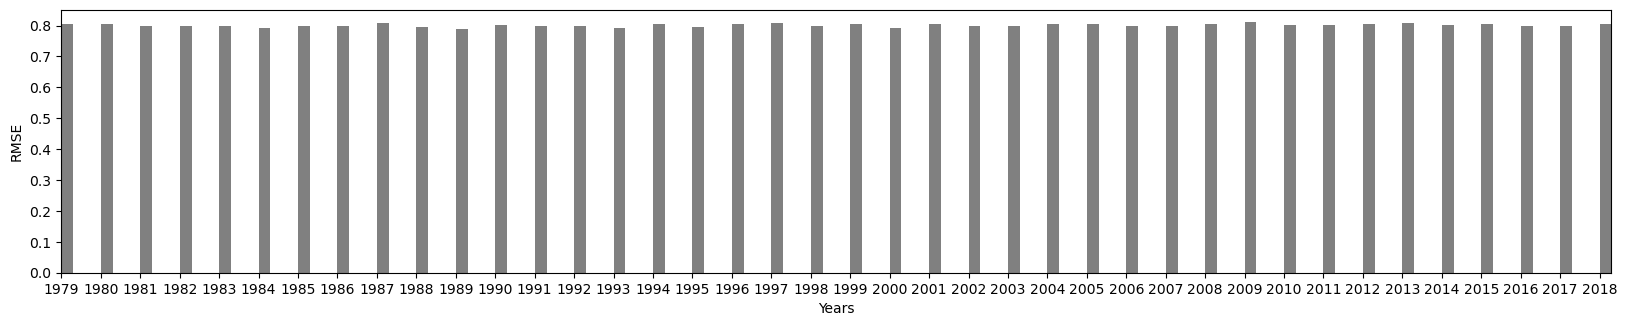

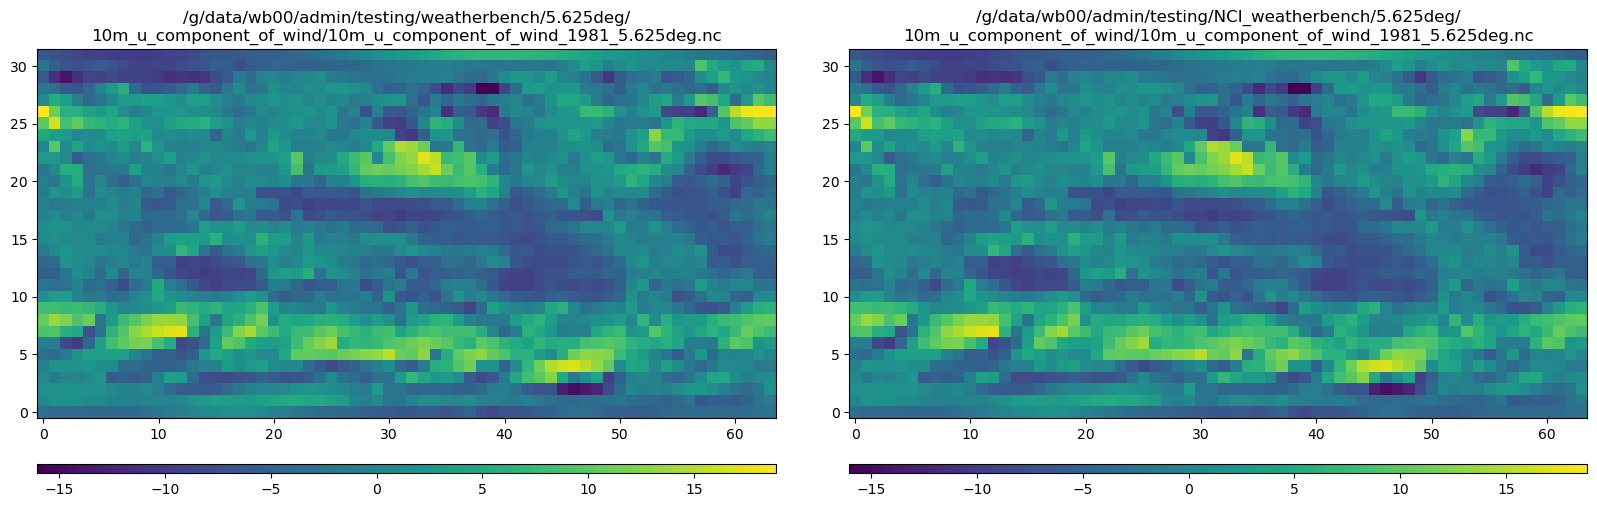

CPU times: user 752 ms, sys: 761 ms, total: 1.51 s
Wall time: 11.9 s


In [87]:
%%time
year_vals = [] 
err_vals  = []
year_vals, err_vals = yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2018, '10m_u_component_of_wind', 'u10')  
#tmp_year , tmp_err  = yearly_rmse_mp (wb_dir, NCI_dir, 2016, 2018, '10m_u_component_of_wind', 'u10')  
#year_vals.extend( tmp_year)
#err_vals .extend( tmp_err ) 
#print ( year_vals  )
display_compare(year_vals, err_vals) 

year = 1981
file1 = wb_dir + '/10m_u_component_of_wind/10m_u_component_of_wind_'+ str(year) + '_5.625deg.nc'
file2 = NCI_dir + '/10m_u_component_of_wind/10m_u_component_of_wind_'+ str(year) + '_5.625deg.nc'
display_single_level(file1, file2, 'u10', 0)

# 10m_v_component_of_wind

2002, 2008, 1979, 1994, 2004, 1983, 2017, 1984, 2009, 1982, 1990, 1995, 2013, 2015, 2000, 1999, 2016, 2010, 1988, 1981, 2006, 1997, 1996, 1980, 2018, 2003, 1986, 2007, 2011, 2001, 2014, 1987, 1985, 2012, 2005, 1991, 1992, 1998, 1993, 1989, 

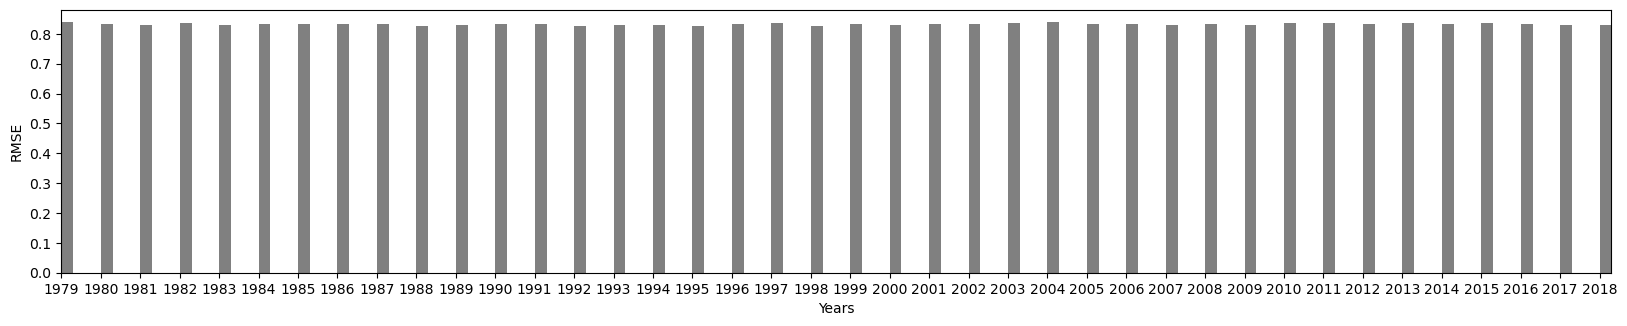

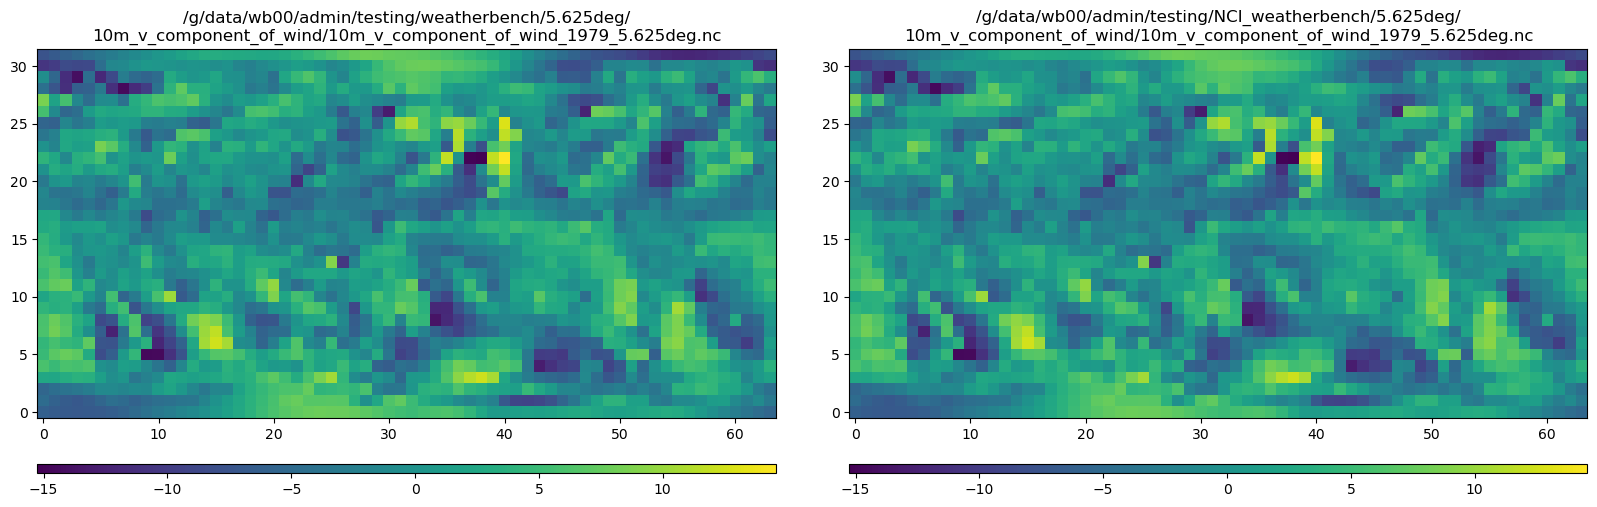

CPU times: user 749 ms, sys: 514 ms, total: 1.26 s
Wall time: 7.15 s


In [17]:
%%time
year_vals = [] 
err_vals  = []
year_vals, err_vals = yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2018, '10m_v_component_of_wind', 'v10') 
#tmp_year , tmp_err  = yearly_rmse_mp (wb_dir, NCI_dir, 2016, 2018, '10m_v_component_of_wind', 'v10') 
#year_vals.extend( tmp_year)
#err_vals .extend( tmp_err ) 
display_compare(year_vals, err_vals)  
    
year = 1979
file1 = wb_dir + '/10m_v_component_of_wind/10m_v_component_of_wind_'+ str(year) + '_5.625deg.nc'
ds_1 = xr.open_dataset(file1)
file2 = NCI_dir + '/10m_v_component_of_wind/10m_v_component_of_wind_'+ str(year) + '_5.625deg.nc'
ds_2 = xr.open_dataset(file2)
display_single_level(file1, file2, 'v10', 0)


# 2m_temperature


1984, 1979, 1992, 2003, 1991, 2002, 1987, 1982, 1998, 1993, 1980, 2016, 1981, 1995, 2009, 1985, 2014, 2000, 2010, 1994, 1986, 1990, 2004, 2007, 1997, 2005, 2018, 1999, 2015, 1996, 2001, 2012, 2017, 1988, 2006, 2011, 2008, 1989, 1983, 2013, 

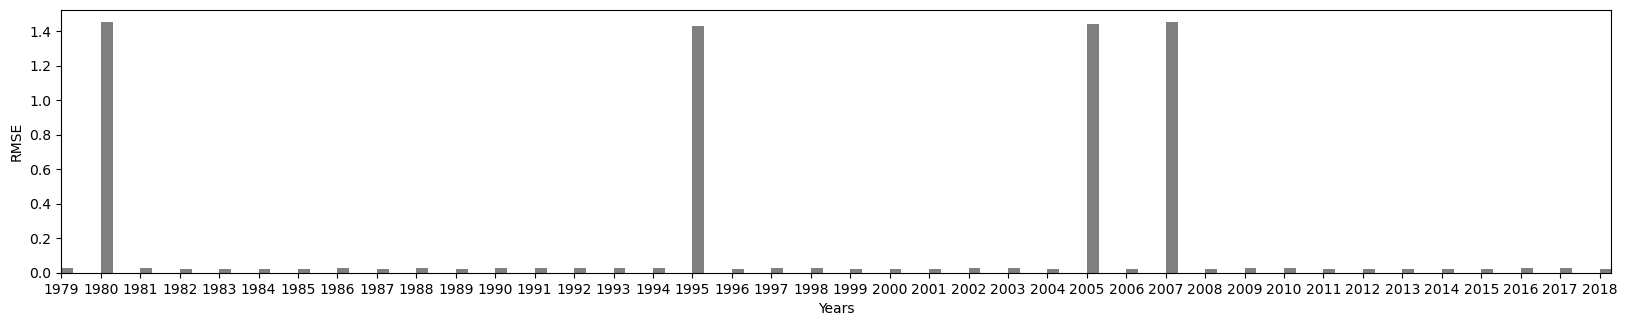

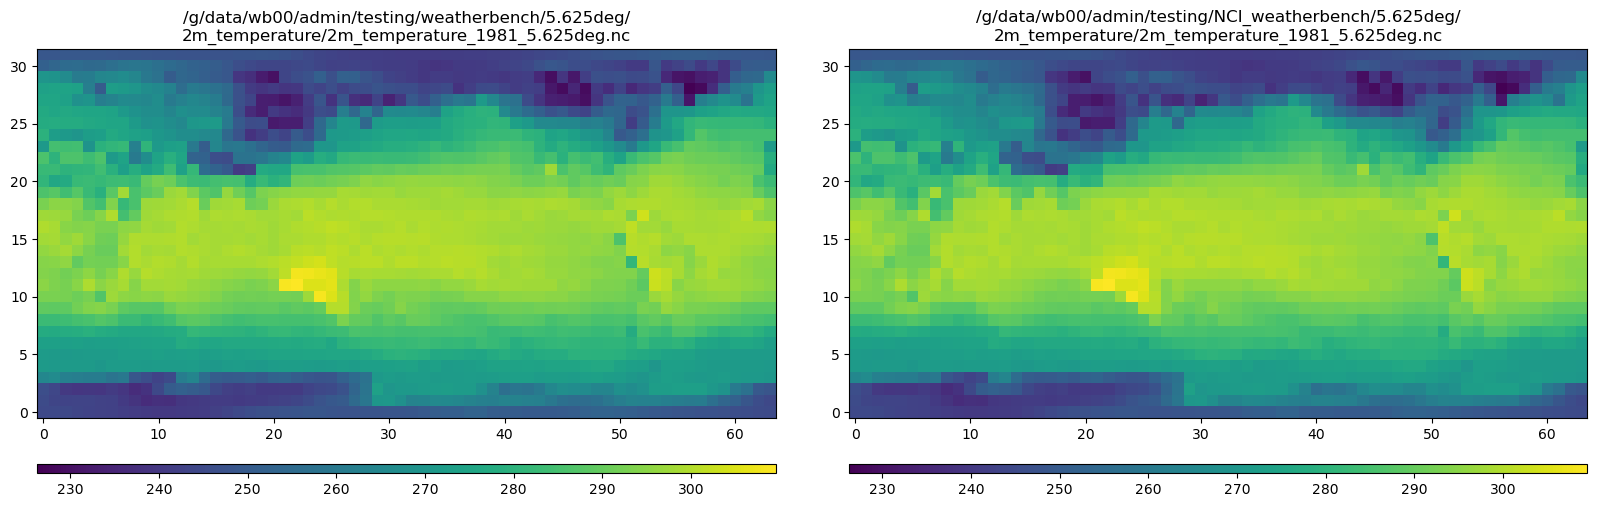

CPU times: user 1.04 s, sys: 366 ms, total: 1.41 s
Wall time: 4.43 s


In [99]:
%%time
err_vals  = []
year_vals = []
year_vals, err_vals = yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2018, '2m_temperature', 't2m') 
#tmp_year , tmp_err  = yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2015, '2m_temperature', 't2m') 
#year_vals.extend( tmp_year)
#err_vals .extend( tmp_err ) 
display_compare(year_vals, err_vals)  
    
year = 1981
file1 = wb_dir + '/2m_temperature/2m_temperature_'+ str(year) + '_5.625deg.nc'
file2 = NCI_dir + '/2m_temperature/2m_temperature_'+ str(year) + '_5.625deg.nc'
display_single_level(file1, file2, 't2m', 0)

# Constants


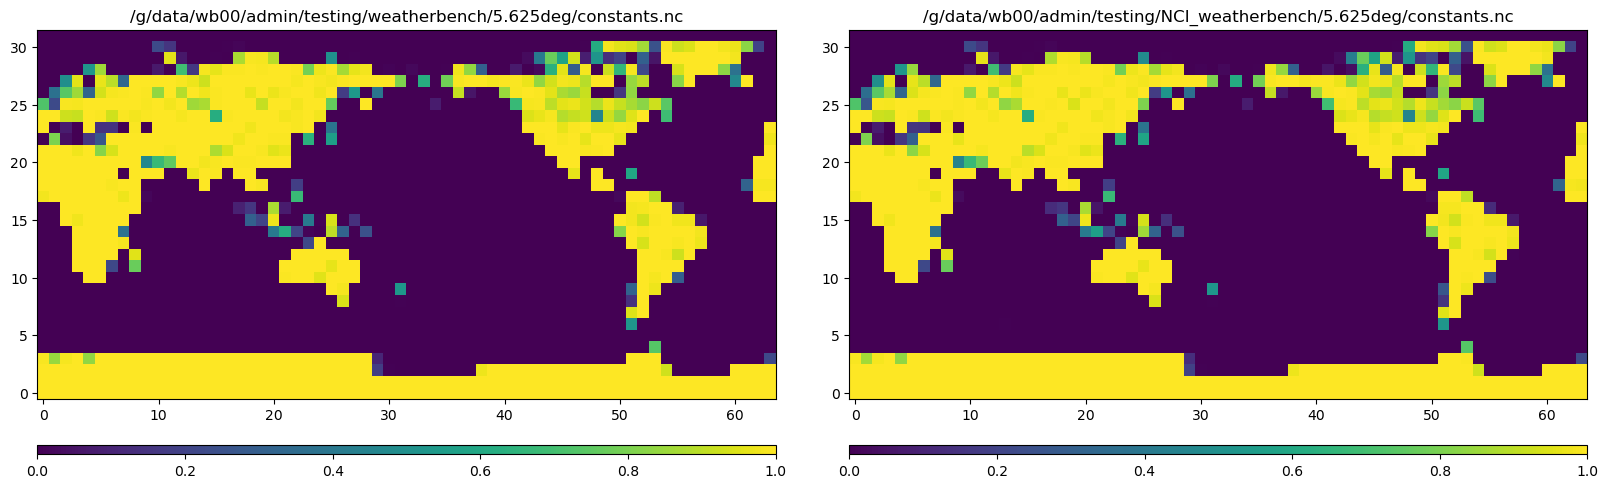

In [19]:
file1 = wb_dir  + '/constants.nc'
file2 = NCI_dir + '/constants.nc'

display_cosntants(file1, file2, 'lsm')

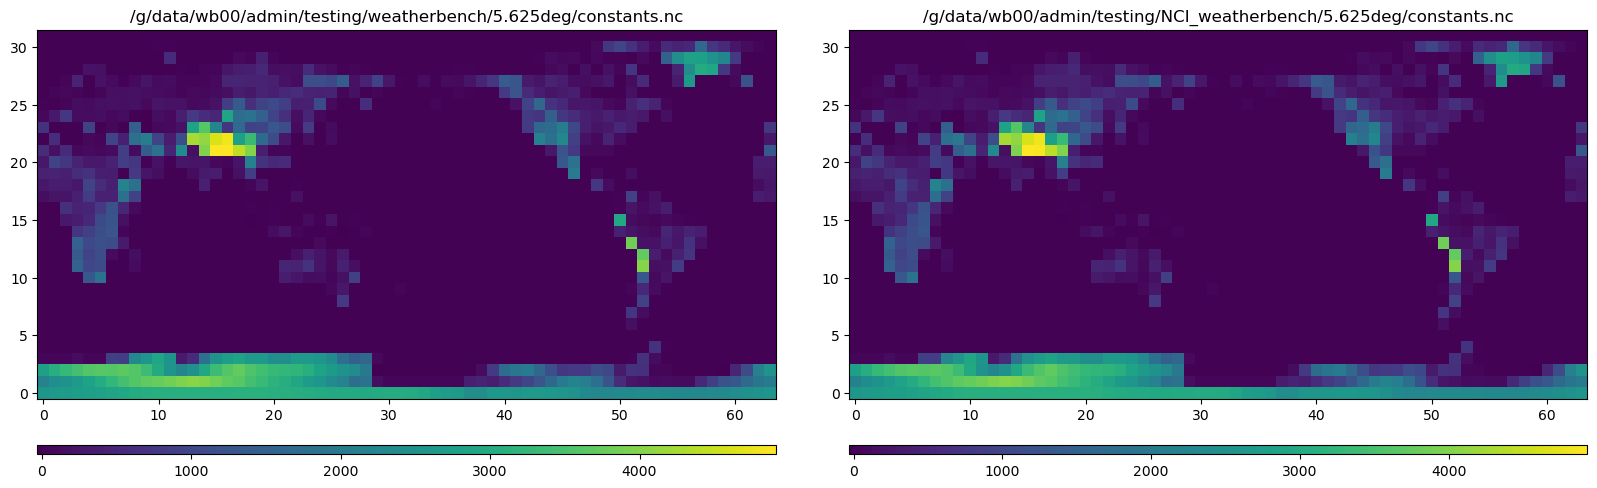

In [22]:
#display_singles(file1, file2, 'orography')
display_cosntants(file1, file2, 'orography')

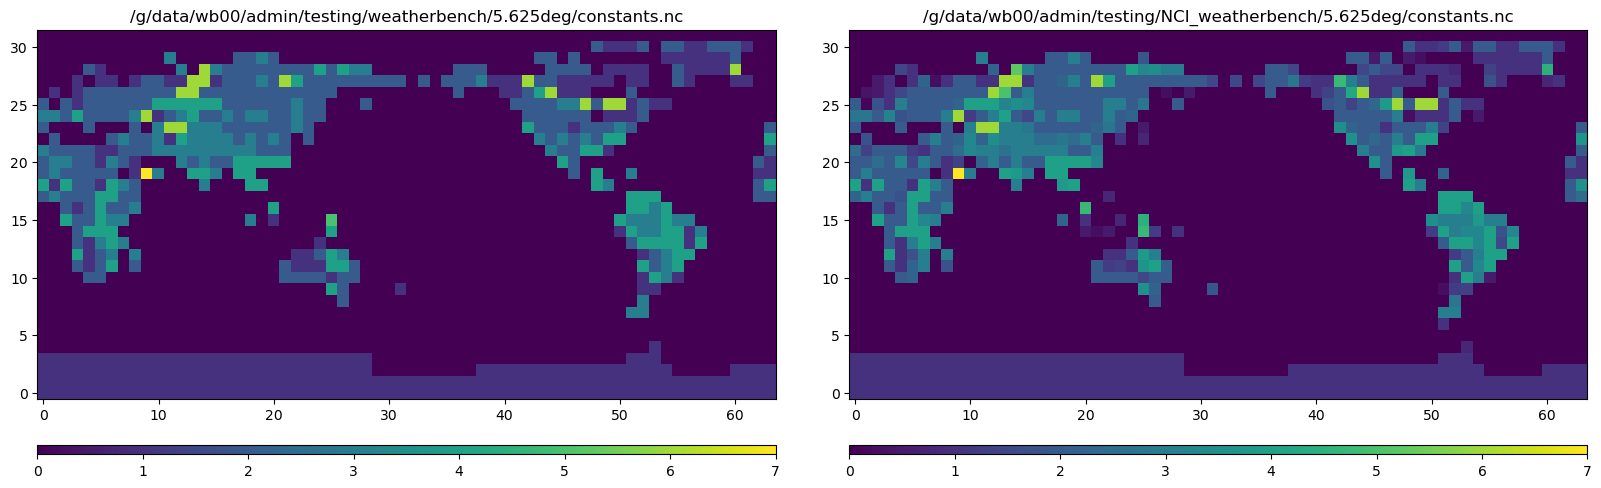

In [24]:
#display_singles(file1, file2, 'slt')
display_cosntants(file1, file2, 'slt')

In [25]:
#display_singles(file1, file2, 'lat2d')
#display_singles(file1, file2, 'lon2d')

# geopotential

1986, 2011, 1987, 2014, 2002, 1984, 1999, 2008, 1982, 1980, 1994, 2009, 1992, 2017, 2016, 2001, 1996, 2006, 1993, 1979, 2010, 1991, 2003, 1988, 2005, 1997, 2013, 2012, 1998, 2000, 2015, 1990, 1981, 2018, 1995, 2004, 1985, 1983, 1989, 2007, 

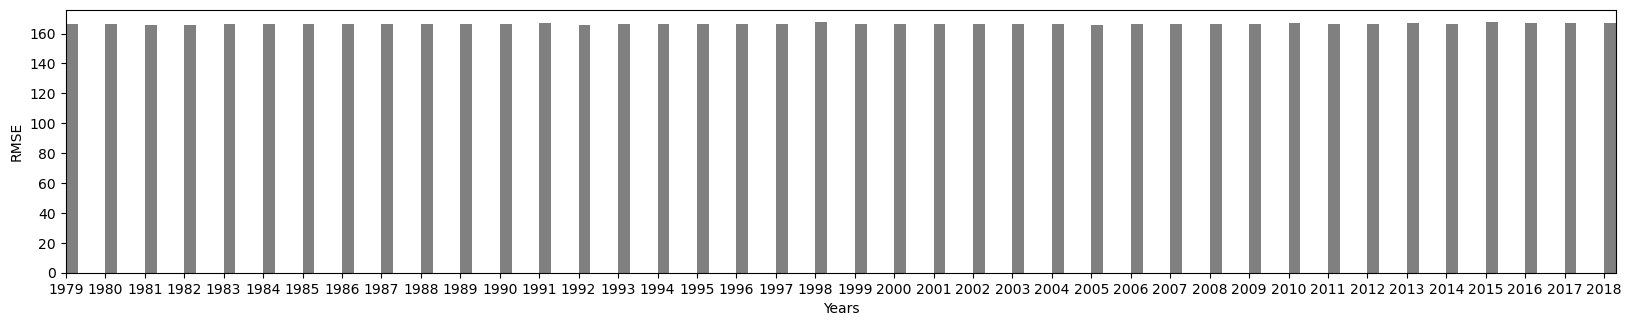

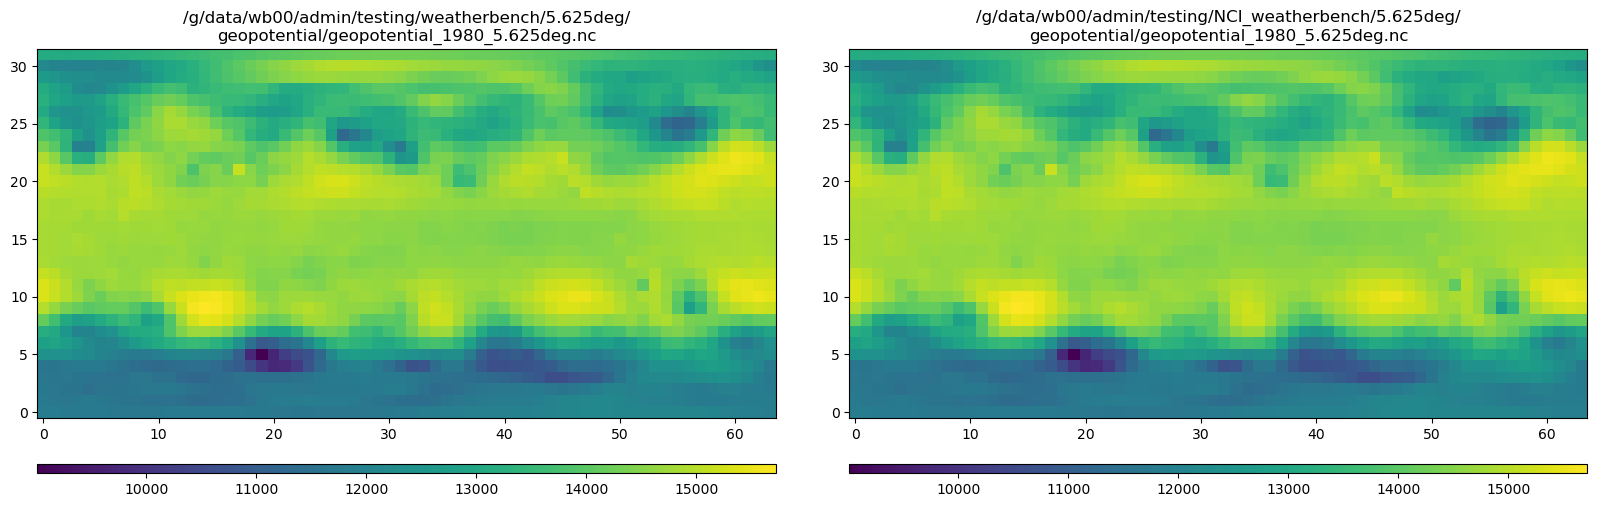

CPU times: user 1.34 s, sys: 2.36 s, total: 3.7 s
Wall time: 38.6 s


In [26]:
%%time 
err_vals  = []
year_vals = []
year_vals, err_vals = yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2018, 'geopotential', 'z')   
#yearly_rmse ('geopotential', 'z')   
display_compare(year_vals, err_vals) 

year = 1980
file1 = wb_dir + '/geopotential/geopotential_'+ str(year) + '_5.625deg.nc'
file2 = NCI_dir + '/geopotential/geopotential_'+ str(year) + '_5.625deg.nc'
display_pressure_level(file1, file2, 'z', 0, 10)

# relative_humidity

1986, 1987, 1981, 1999, 1996, 2015, 1994, 1995, 1988, 2006, 2000, 1993, 2010, 2012, 2005, 2007, 1991, 1985, 2009, 1989, 2004, 2011, 2002, 1980, 1982, 2001, 1984, 2018, 2008, 1979, 2014, 1983, 1992, 1990, 1998, 2016, 2003, 2017, 1997, 2013, 

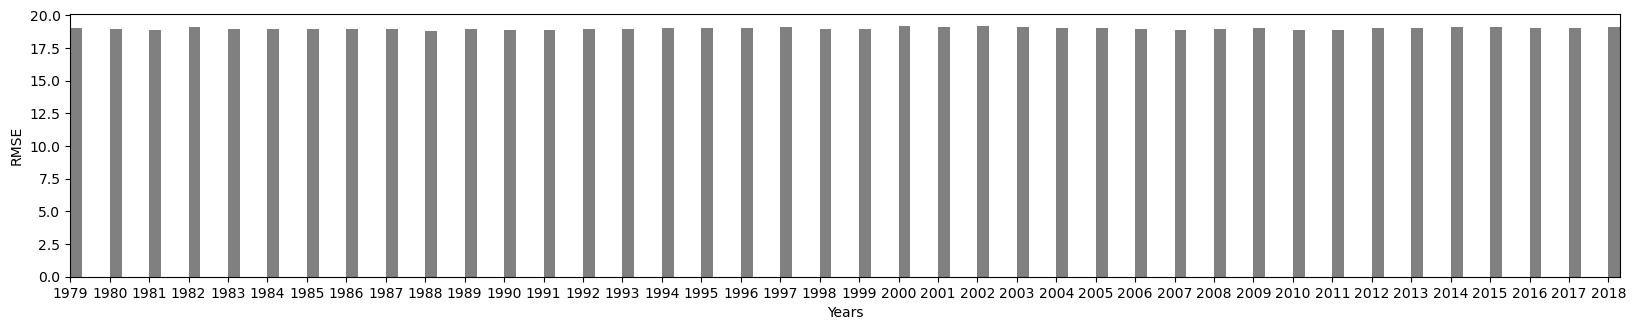

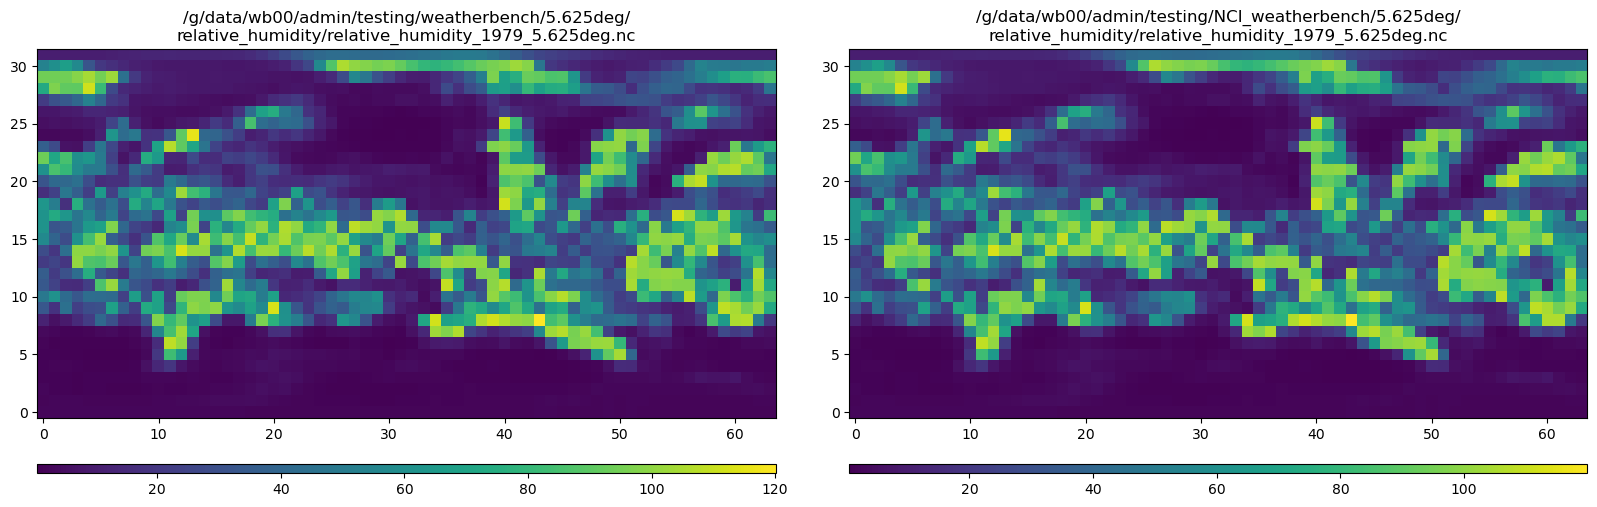

CPU times: user 878 ms, sys: 2.68 s, total: 3.56 s
Wall time: 42.2 s


In [27]:
%%time
#del err_vals 
#del year_vals
err_vals  = []
year_vals = []
#yearly_rmse ('relative_humidity', 'r')   
year_vals, err_vals = yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2018, 'relative_humidity', 'r')   
display_compare(year_vals, err_vals) 

year = 1979
file1 = wb_dir + '/relative_humidity/relative_humidity_'+ str(year) + '_5.625deg.nc'
file2 = NCI_dir + '/relative_humidity/relative_humidity_'+ str(year) + '_5.625deg.nc'
display_pressure_level(file1, file2, 'r', 0, 3)

# specific_humidity

1995, 1983, 2002, 1985, 1993, 2016, 1990, 1987, 1996, 1991, 2015, 2008, 1986, 2011, 2017, 2012, 2006, 1979, 2000, 1997, 1994, 2018, 1988, 1992, 2001, 1984, 2013, 2010, 1999, 1981, 1989, 2007, 2004, 2003, 2014, 2009, 1998, 1982, 1980, 2005, 

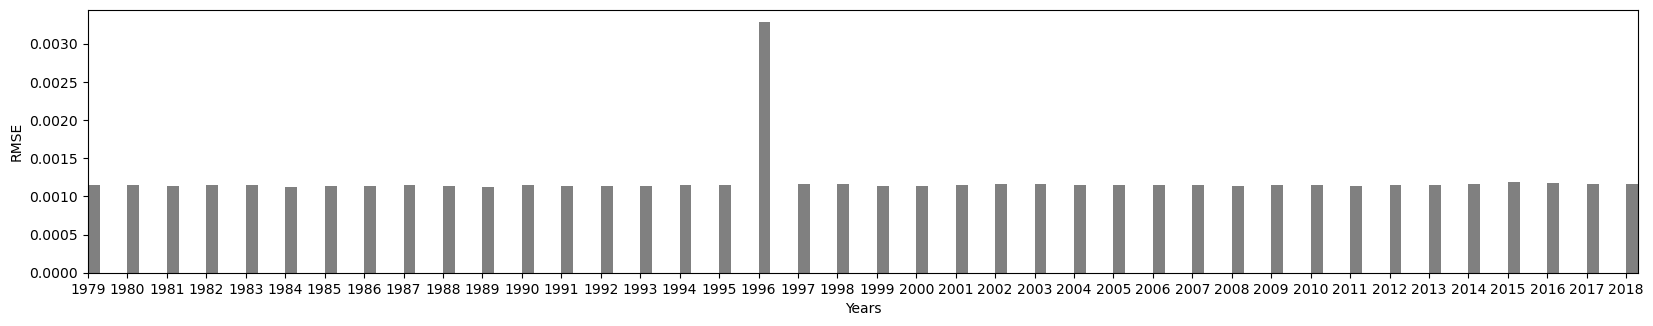

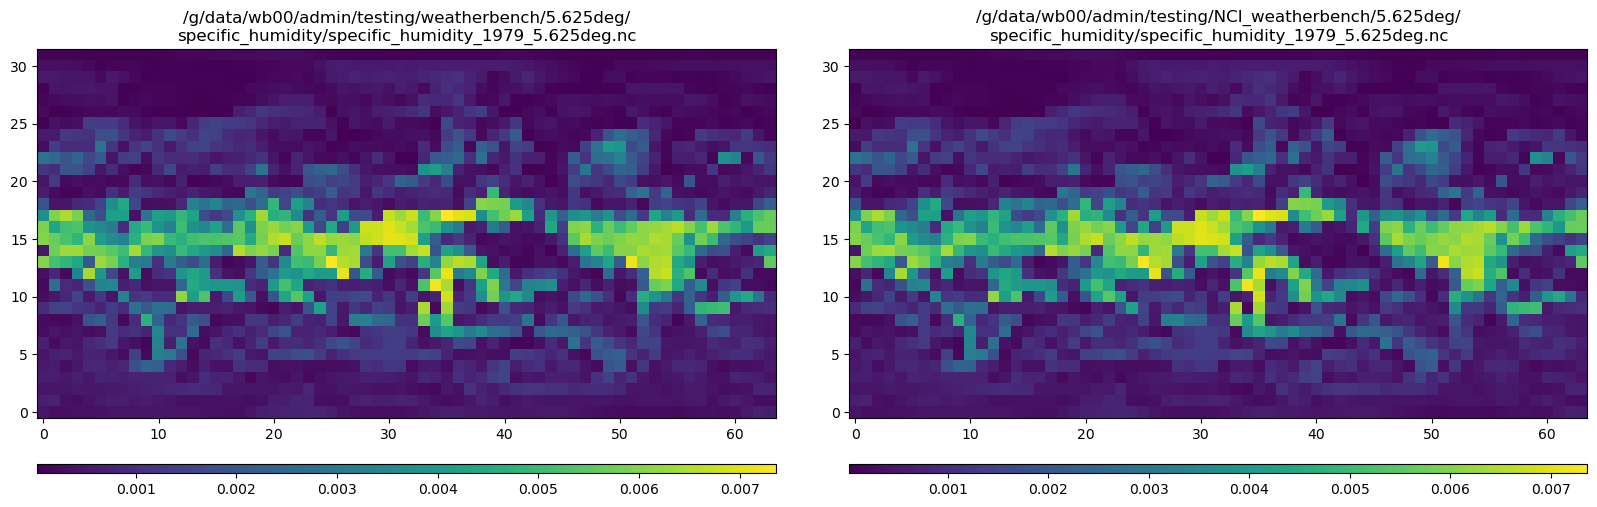

In [28]:
del err_vals 
del year_vals
err_vals  = []
year_vals = []
#yearly_rmse ('specific_humidity', 'q') 
year_vals, err_vals = yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2018, 'specific_humidity', 'q')   
display_compare(year_vals, err_vals) 

year = 1979
file1 = wb_dir  + '/specific_humidity/specific_humidity_'+ str(year) + '_5.625deg.nc'
file2 = NCI_dir + '/specific_humidity/specific_humidity_'+ str(year) + '_5.625deg.nc'
display_pressure_level(file1, file2, 'q', 0, 8)

# temperature

1979, 1982, 1998, 2008, 1987, 2004, 1995, 2017, 2002, 2013, 2014, 1990, 2011, 2016, 1988, 2012, 2005, 1996, 1994, 2003, 2006, 2010, 1981, 2007, 1992, 1983, 1989, 2000, 2018, 1984, 1997, 1991, 2015, 1985, 2009, 1980, 1993, 1999, 2001, 1986, 

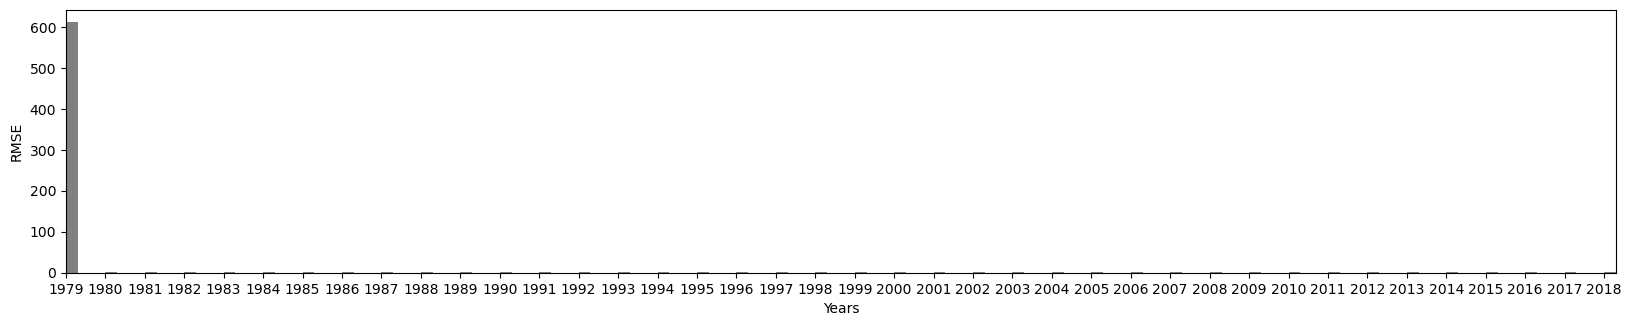

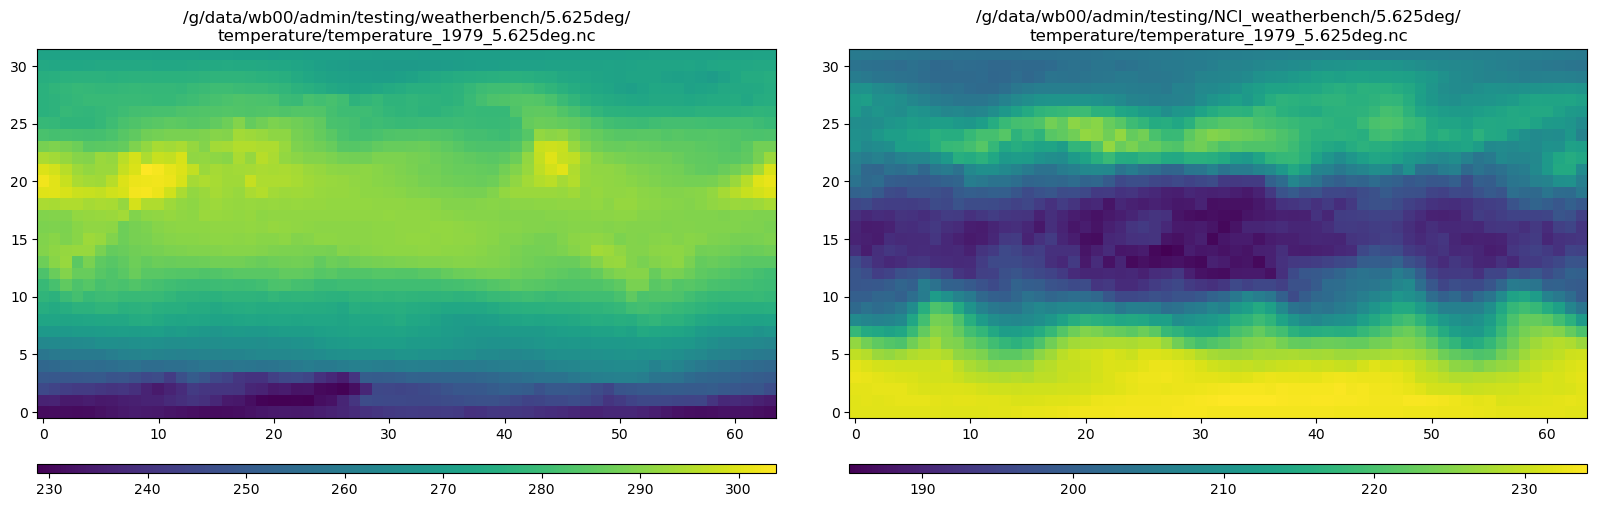

CPU times: user 976 ms, sys: 2.46 s, total: 3.44 s
Wall time: 40.2 s


In [29]:
%%time
err_vals  = []
year_vals = []
year_vals, err_vals = yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2018, 'temperature', 't')   
#yearly_rmse ('temperature', 't')   
display_compare(year_vals, err_vals) 

year = 1979
file1 = wb_dir  + '/temperature/temperature_'+ str(year) + '_5.625deg.nc'
file2 = NCI_dir + '/temperature/temperature_'+ str(year) + '_5.625deg.nc'
display_pressure_level(file1, file2, 't', 150, 10)

# u_component_of_wind

2001, 1992, 1979, 2015, 1994, 1990, 2014, 1995, 2012, 1985, 2011, 1983, 2013, 2004, 1997, 2016, 2002, 1993, 1991, 1989, 2018, 1987, 2000, 1981, 2009, 1986, 2007, 2003, 1982, 2005, 2006, 1996, 1984, 2017, 1998, 1980, 2010, 2008, 1999, 1988, 

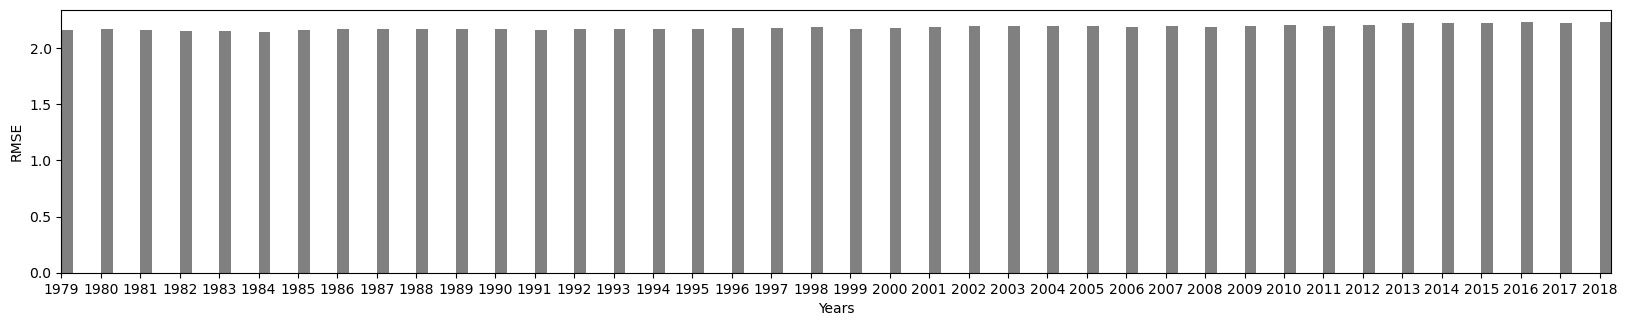

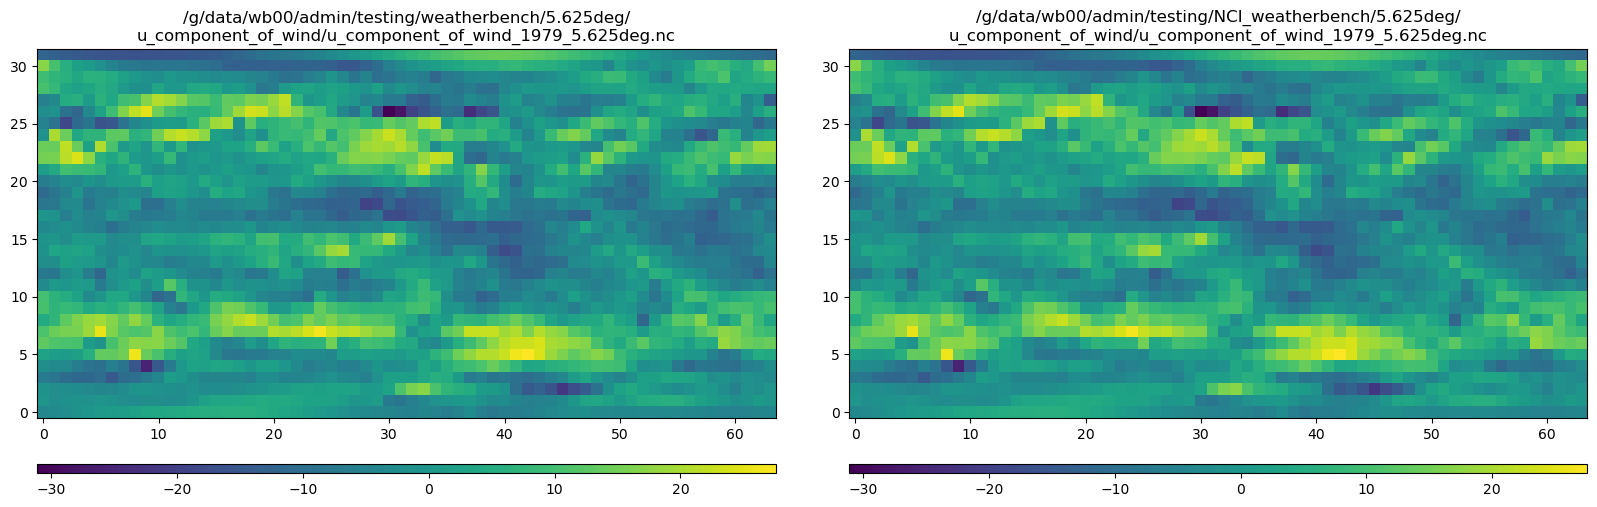

CPU times: user 829 ms, sys: 2.28 s, total: 3.11 s
Wall time: 36.9 s


In [30]:
%%time
err_vals  = []
year_vals = []
year_vals, err_vals = yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2018, 'u_component_of_wind', 'u')  
#yearly_rmse ('u_component_of_wind', 'u')   
display_compare(year_vals, err_vals) 

year = 1979
file1 = wb_dir  + '/u_component_of_wind/u_component_of_wind_'+ str(year) + '_5.625deg.nc'
file2 = NCI_dir + '/u_component_of_wind/u_component_of_wind_'+ str(year) + '_5.625deg.nc'
display_pressure_level(file1, file2, 'u', 0, 10)

# v_component_of_wind

2012, 1984, 2005, 1994, 2000, 1993, 1987, 1983, 1992, 1981, 2015, 1985, 2018, 2014, 1998, 2017, 1991, 1999, 2013, 1997, 2004, 1980, 2009, 2006, 2016, 1979, 2001, 2003, 1996, 2002, 2008, 2007, 1988, 1982, 1986, 2011, 1989, 1995, 2010, 1990, 

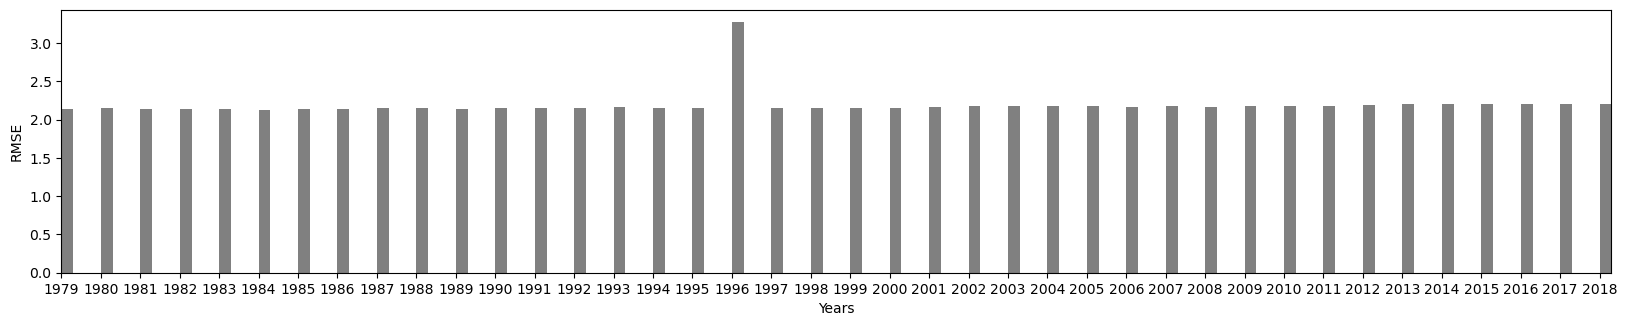

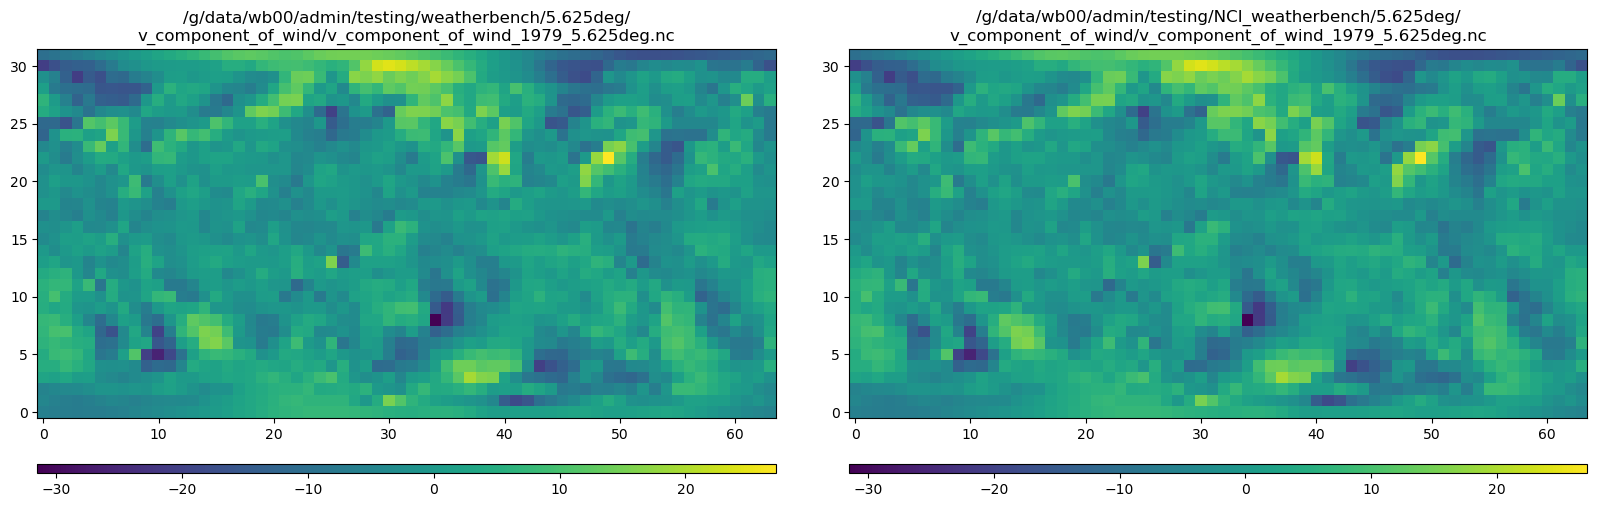

CPU times: user 838 ms, sys: 2.73 s, total: 3.57 s
Wall time: 38.9 s


In [ ]:
%%time
err_vals  = []
year_vals = []
year_vals, err_vals = yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2018, 'v_component_of_wind', 'v') 
#yearly_rmse ('v_component_of_wind', 'v')     
display_compare(year_vals, err_vals )

year = 1979
file1 = wb_dir  + '/v_component_of_wind/v_component_of_wind_'+ str(year) + '_5.625deg.nc'
file2 = NCI_dir + '/v_component_of_wind/v_component_of_wind_'+ str(year) + '_5.625deg.nc'
display_pressure_level(file1, file2, 'v', 0, 10)

# total_precipitation

2000, 1991, 2008, 1989, 2009, 2002, 1984, 1985, 1993, 1999, 1998, 2012, 1994, 2007, 1997, 2003, 1990, 2017, 2018, 1986, 1992, 2010, 1995, 2004, 2014, 2005, 1983, 1996, 1988, 2011, 1982, 1980, 2001, 1987, 2006, 2016, 1981, 2013, 2015, 1979, 

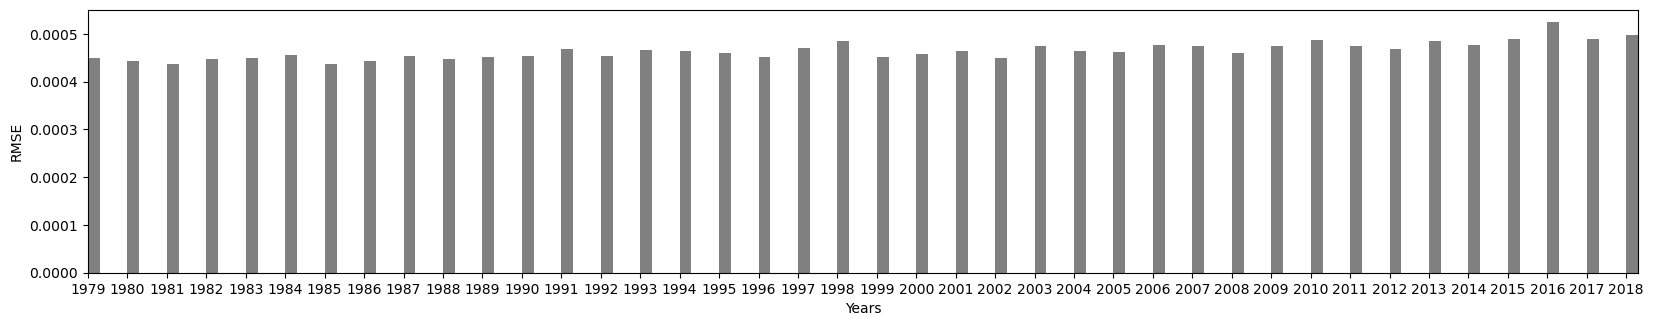

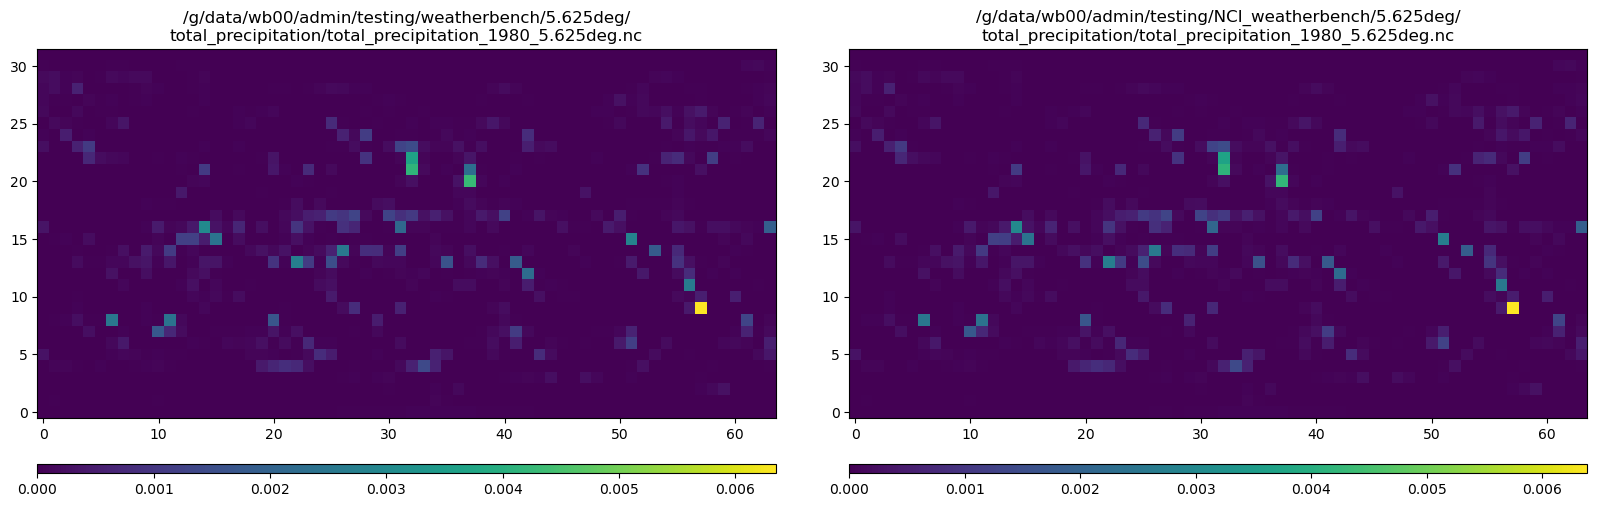

CPU times: user 970 ms, sys: 706 ms, total: 1.68 s
Wall time: 14.5 s


In [36]:
%%time
err_vals  = []
year_vals = []
year_vals, err_vals = yearly_rmse_mp (wb_dir, NCI_dir, 1979, 2018, 'total_precipitation', 'tp') 
#yearly_rmse ('total_precipitation', 'tp')  
display_compare(year_vals, err_vals)

year = 1980
file1 = wb_dir  + '/total_precipitation/total_precipitation_'+ str(year) + '_5.625deg.nc'
file2 = NCI_dir + '/total_precipitation/total_precipitation_'+ str(year) + '_5.625deg.nc'
#display_compare(file1, file2,  'tp', 0)  
display_single_level(file1, file2, 'tp', 0)

In [ ]:
#import multiprocessing
#multiprocessing.cpu_count()